<a href="https://colab.research.google.com/github/PondKann/CXR-Project/blob/main/TransferL_KaggleDataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [89]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [90]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
train_dir = '/content/drive/My Drive/Senior Project/xray_dataset_covid19/train'
validation_dir = '/content/drive/My Drive/Senior Project/xray_dataset_covid19/test'

In [4]:
data_gen_train = ImageDataGenerator(rescale=1/255.)
data_gen_valid = ImageDataGenerator(rescale=1/255.)

In [5]:
train_generator = data_gen_train.flow_from_directory(train_dir,target_size=(128,128), batch_size=128, class_mode= "binary" )
valid_generator = data_gen_train.flow_from_directory(validation_dir, target_size=(128,128), batch_size=128, class_mode= "binary" )

Found 148 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


### MobileNetV2
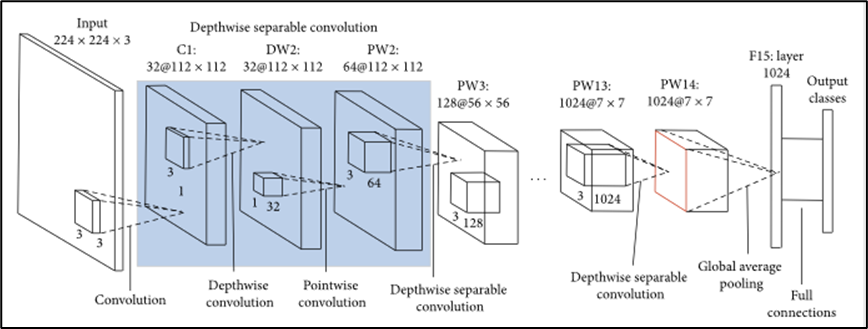

In [41]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(128,128,3), include_top=False, weights="imagenet")

In [7]:
base_model.summary()

Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 64, 64, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 64, 64, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 64, 64, 32)   0           ['bn_Conv1[0][

In [42]:
base_model.trainable=False   #ล็อก W 

Add custom head

In [43]:
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
prediction_layer = tf.keras.layers.Dense(units=1, activation="sigmoid")(average_pooling_layer)

In [44]:
model = tf.keras.models.Model(inputs=base_model.input, outputs=prediction_layer)

In [11]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 64, 64, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 64, 64, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 64, 64, 32)   0           ['bn_Conv1[0][0]']           

Train model

In [45]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [34]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=2,
    mode="max"
)
#จะหยุดเทรนเมื่อ val loss ไม่เพิ่มขึ้นขึ้น 2 รอบ

In [46]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=2,
    mode="max"
)

In [47]:
model.fit_generator(train_generator, epochs=7, validation_data=valid_generator, callbacks=[callback])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """Entry point for launching an IPython kernel.


Epoch 1/7
2/2 [==============================] - 14s 4s/step - loss: 0.8534 - accuracy: 0.5338 - val_loss: 0.8874 - val_accuracy: 0.4250
Epoch 2/7
2/2 [==============================] - 9s 8s/step - loss: 0.7718 - accuracy: 0.5608 - val_loss: 0.8519 - val_accuracy: 0.3000
Epoch 3/7
2/2 [==============================] - 9s 2s/step - loss: 0.7493 - accuracy: 0.5608 - val_loss: 0.8307 - val_accuracy: 0.3000


Fine tuning

In [48]:
len(base_model.layers)

154

In [49]:
base_model.trainable = True

In [50]:
for layer in base_model.layers[:100]:    #fix w & bias in layer 0-100 
    layer.trainable = False

In [51]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.0001),
              loss="binary_crossentropy", metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [52]:
model.fit_generator(train_generator, epochs=10, 
                    validation_data=valid_generator,
                    callbacks=[callback])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/10
2/2 [==============================] - 18s 4s/step - loss: 0.6222 - accuracy: 0.6351 - val_loss: 0.3935 - val_accuracy: 0.8500
Epoch 2/10
2/2 [==============================] - 10s 9s/step - loss: 0.0423 - accuracy: 1.0000 - val_loss: 0.3547 - val_accuracy: 0.8750
Epoch 3/10
2/2 [==============================] - 10s 8s/step - loss: 0.0256 - accuracy: 1.0000 - val_loss: 0.3393 - val_accuracy: 0.9000
Epoch 4/10
2/2 [==============================] - 10s 2s/step - loss: 0.0149 - accuracy: 1.0000 - val_loss: 0.3249 - val_accuracy: 0.9000
Epoch 5/10
2/2 [==============================] - 10s 9s/step - loss: 0.0103 - accuracy: 1.0000 - val_loss: 0.3044 - val_accuracy: 0.9000


### DenseNet201
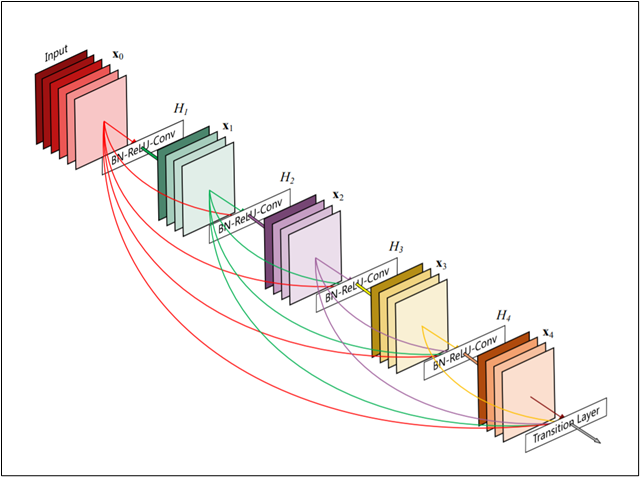

In [69]:
base_model2 = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")

In [54]:
base_model2.summary()

Model: "densenet201"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_3[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                        

In [70]:
base_model2.trainable=False

Add custom head

In [71]:
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model2.output)
prediction_layer = tf.keras.layers.Dense(units=1, activation="sigmoid")(average_pooling_layer)

In [72]:
model2 = tf.keras.models.Model(inputs=base_model2.input, outputs=prediction_layer)

In [73]:
model2.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_4 (ZeroPadding2  (None, 230, 230, 3)  0          ['input_5[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d_4[0][0]']       
                                )                                                           

Train model

In [74]:
model2.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [77]:
callback2 = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=2,
    mode="max")

In [79]:
model2.fit_generator(train_generator, epochs=10, 
                    validation_data=valid_generator,
                    callbacks=[callback2])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/10
2/2 [==============================] - 21s 18s/step - loss: 0.6844 - accuracy: 0.6081 - val_loss: 0.7873 - val_accuracy: 0.5250
Epoch 2/10
2/2 [==============================] - 20s 17s/step - loss: 0.6707 - accuracy: 0.6284 - val_loss: 0.7722 - val_accuracy: 0.5500
Epoch 3/10
2/2 [==============================] - 20s 6s/step - loss: 0.6600 - accuracy: 0.6486 - val_loss: 0.7535 - val_accuracy: 0.6000
Epoch 4/10
2/2 [==============================] - 20s 17s/step - loss: 0.6388 - accuracy: 0.6689 - val_loss: 0.7373 - val_accuracy: 0.5750
Epoch 5/10
2/2 [==============================] - 21s 6s/step - loss: 0.6298 - accuracy: 0.6757 - val_loss: 0.7242 - val_accuracy: 0.6000


Fine tuning

In [82]:
len(base_model2.layers)

707

In [84]:
base_model2.trainable = True

In [85]:
for layer in base_model2.layers[:500]:    #fix w & bias in layer 0-500
    layer.trainable = False

In [86]:
model2.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.0001),
              loss="binary_crossentropy", metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [87]:
model2.fit_generator(train_generator, epochs=10, 
                    validation_data=valid_generator,
                    callbacks=[callback2])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/10
2/2 [==============================] - 50s 11s/step - loss: 0.6539 - accuracy: 0.5608 - val_loss: 0.1425 - val_accuracy: 0.9500
Epoch 2/10
2/2 [==============================] - 24s 20s/step - loss: 0.0389 - accuracy: 0.9932 - val_loss: 0.1363 - val_accuracy: 0.9250
Epoch 3/10
2/2 [==============================] - 25s 6s/step - loss: 0.0153 - accuracy: 1.0000 - val_loss: 0.1224 - val_accuracy: 0.9250
